# QKeras dense layer comparison


This notebook is made to create quantized fully connected network and compare the two quantization method Post Training Quantization (PTQ) and Quantization Aware Training (QAT)

## Imports

In [8]:
import tensorflow as tf
import keras
import numpy as np
import time
import random

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from collections import deque


from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *

import hls4ml


## Data creation 

In [9]:
#Creating a simple dataset using numpy

x = np.linspace(-1, 1, 1000)
y = np.sin(5*x)

x_val = np.linspace(-1, 1, 100)
y_val = np.sin(5*x_val)

x_test = np.linspace(-1, 1, 1000)
y_test = np.sin(5*x_test)



## Settings

In [10]:
output = 1
integer = (3)

def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+4)

def bit_width(i): return {'bits': (i+4), 'integer': integer, 'symmetric': 0, 'alpha':1}

bits_range = 12

nbr_epoch = 15

def units(j): return (j+2)*2
units_range = 12

In [11]:
def exist(path,modeltopred):
    if (os.path.exists(path)==False):
        np.save(path, modeltopred.predict(x_test.reshape(x_test.shape[0],1)))
        op=np.load(path)     
    else:
        op=np.load(path)     
  
    return op 
    
def existnorm(path,modeltopred):
    if (os.path.exists(path)==False):
        np.save(path, modeltopred.predict(x_test))
        op=np.load(path)
     
    else : 
        print(f'{path} already exists')
        op=np.load(path)
    return op



In [22]:
#path

def models_path(unit): return f"../tests/models/models_{units(unit)}.h5"
def predicts_path(unit): return f"../tests/predicts/models_{units(unit)}.npy"

def qmodels_path(bits, unit): return f"C:/Users/raph2/Desktop/Stage M1/Stage/code/internship_CPPM/final/Part1_Dense/tests/qmodels/models_{units(unit)}_<{bit_lenghts(bits)},{integer}>.h5" 
def qpredicts_path(bits, unit): return f"../tests/qpredicts/models_{units(unit)}_<{bit_lenghts(bits)},{integer}>.npy" 
def qpredicts_path_PTQ(bits, unit): return f"../tests/qpredicts/modelsPTQ_{units(unit)}_<{bit_lenghts(bits)},{integer}>.npy" 
def qpredicts_path_QAT(bits, unit): return f"../tests/qpredicts/modelsQAT_{units(unit)}_<{bit_lenghts(bits)},{integer}>.npy" 

## Classic network

In [17]:
def normal_model (units_parameter):
    checkpoint_filepath = '/atlas/bonnet/tmp/model_checkpoint'

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=5, min_lr=0.00001, verbose=1)

    d_model = Sequential()

    d_model.add(Dense(units_parameter,input_dim= 1,activation='relu', name='dense'))
    d_model.add(Dense(units_parameter,activation='relu', name='dense_1'))
    d_model.add(Dense(output, activation='linear', name='dense_2'))
    d_model.compile(loss="mse", optimizer=Adam(lr=0.001))

    d_model.summary()

    d_model.fit(x, y, validation_data= (x_val,y_val), epochs=80, batch_size=10, callbacks=[reduce_lr,model_checkpoint_callback])

    d_model.load_weights(checkpoint_filepath)

    return d_model

def model_saving (): 
    models =[]
    for i in range(units_range):
        if (os.path.exists(models_path(i))==False):
            units_parameter = units (i)
            model = normal_model (units_parameter)
           
            model.save(models_path(i))
            print('number of units ', units_parameter)
        else :
            print(f'{models_path(i)} already exists')
            model = keras.models.load_model(models_path(i))
        models.append(model)       
             
    return models

models = model_saving()
print (models)

../tests/models/models_4.h5 already exists
../tests/models/models_6.h5 already exists
../tests/models/models_8.h5 already exists
../tests/models/models_10.h5 already exists
../tests/models/models_12.h5 already exists
../tests/models/models_14.h5 already exists
../tests/models/models_16.h5 already exists
../tests/models/models_18.h5 already exists
../tests/models/models_20.h5 already exists
../tests/models/models_22.h5 already exists
../tests/models/models_24.h5 already exists
../tests/models/models_26.h5 already exists
[<keras.engine.sequential.Sequential object at 0x000001DADA1B5040>, <keras.engine.sequential.Sequential object at 0x000001DADD876F10>, <keras.engine.sequential.Sequential object at 0x000001DADA1B5C40>, <keras.engine.sequential.Sequential object at 0x000001DADE960A30>, <keras.engine.sequential.Sequential object at 0x000001DADA1B5670>, <keras.engine.sequential.Sequential object at 0x000001DADE98F880>, <keras.engine.sequential.Sequential object at 0x000001DADE9CB490>, <kera

## Quantized network : 

In [23]:
def quantized_model (bits, units, original_weights):
    qcheckpoint_filepath = '../tmp/qmodel_checkpoint'
    qmodel_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=qcheckpoint_filepath,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)


    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001, verbose=1)

    qd_model = Sequential()
    
    qd_model.add(QDense(units,
                        input_dim= 1,
                        activation='relu',   
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)))
    
    qd_model.add(QDense(units,
                        activation='relu',   
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)))    
    #qd_model.add(QActivation(activation=quantized_relu(bits=bits['bits'], integer = bits['integer']), name='relu1'))                   
    qd_model.add(QDense(output, 
                        activation='linear',
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)))
    #qd_model.add(QActivation(activation=quantized_bits(**bits), name='linear1'))
    qd_model.compile(loss="mse", optimizer=Adam(lr=0.0001))
    
    qd_model.summary()
    
    #using the weight from the classic network as a base
    qd_model.set_weights(original_weights.get_weights())
    qd_model.fit(x, y, validation_data= (x_val,y_val),epochs = nbr_epoch, callbacks=[qmodel_checkpoint_callback,reduce_lr])
    qd_model.load_weights(qcheckpoint_filepath)

    return qd_model

def qmodel_saving (): 
    qmodels =[]
    for i in range(bits_range):
        var_units= []
        for j in range(units_range):
            bits_parameter = bit_width(i)
            units_parameter = units(j)
            if (os.path.exists(qmodels_path(i,j))==False):
                
                qmodel =quantized_model(bits_parameter,units_parameter, models[j])
                qmodel.save(qmodels_path(i,j))
                print( 'bit width ', bits_parameter)               
                var_units.append(qmodel)
            else :
                bits_parameter = bit_width(i)
                units_parameter = units(j)
                qmodel = qkeras.utils.load_qmodel(qmodels_path(i,j))
                var_units.append(qmodel)

            qmodels.append(var_units)
            print( 'bit width ', bits_parameter)        
    return qmodels
        
qmodels = qmodel_saving()
        


C:\Users\raph2\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
q_dense_12 (QDense)          (None, 4)                 8         
_________________________________________________________________
q_dense_13 (QDense)          (None, 4)                 20        
_________________________________________________________________
q_dense_14 (QDense)          (None, 1)                 5         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
32/32 [==============================] - 1s 6ms/step - loss: 4.9293 - val_loss: 5.0007
Epoch 2/15
32/32 [==============================] - 0s 2ms/step - loss: 4.9293 - val_loss: 5.0007
Epoch 3/15
32/32 [==============================] - 0s 1ms/step - loss: 5.4075 - val_loss: 5.6013
Epoch 4/15
32/32 [==============================] - 0s 2ms/step - loss: 5.5354 - val_loss: 5.6

OSError: Unable to create file (unable to open file: name = 'C:/Users/raph2/Desktop/Stage M1/Stage/code/internship_CPPM/final/Part1_Dense/tests/qmodels/models_4_<4,3>.h5', errno = 22, error message = 'Invalid argument', flags = 13, o_flags = 302)

In [18]:
print((qmodels)) 

for i  in range (bits_range):   
    print(quantized_bits(**bit_width(i)))

NameError: name 'qmodels' is not defined

## HLS PTQ : CONVERSION  the Keras model, only dense layer

In [52]:
#CHOOSE THE NULBER OF UNIT 

j=2  # /!\ unit=(j+2)*2

PTQ : bitwidths of (4,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

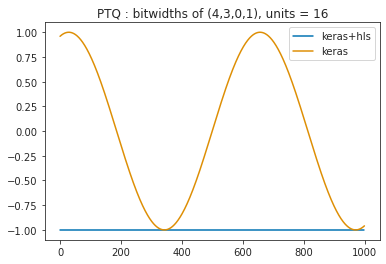

PTQ : bitwidths of (5,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

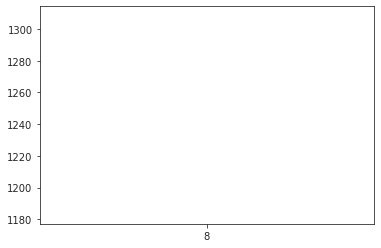

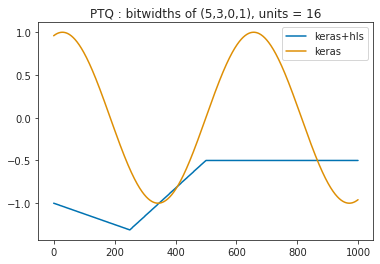

PTQ : bitwidths of (6,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

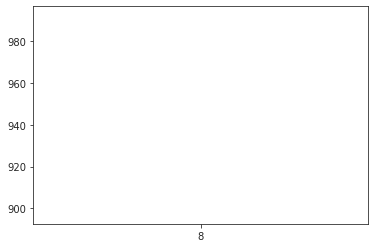

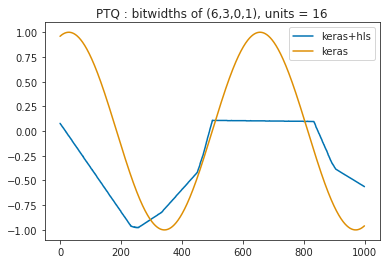

PTQ : bitwidths of (7,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

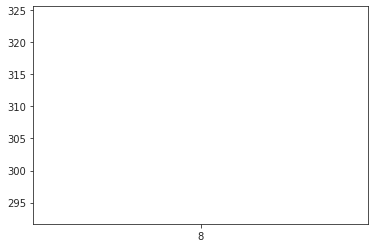

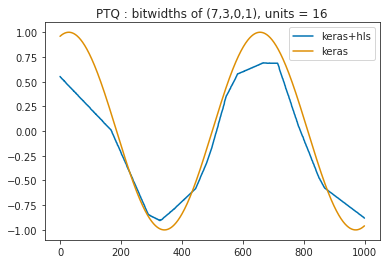

PTQ : bitwidths of (8,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

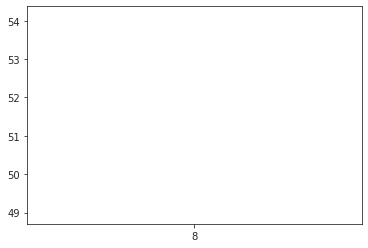

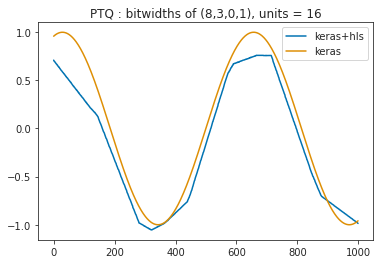

PTQ : bitwidths of (9,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

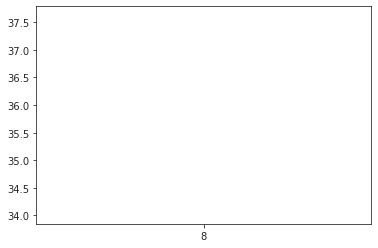

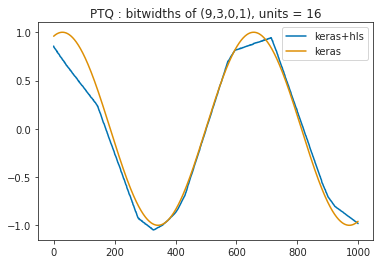

PTQ : bitwidths of (10,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

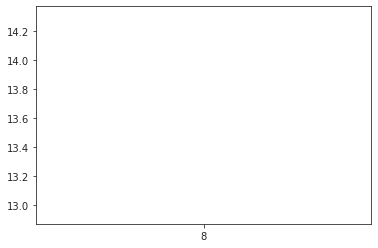

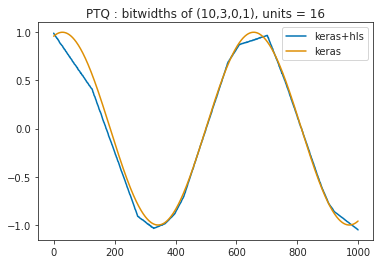

PTQ : bitwidths of (11,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

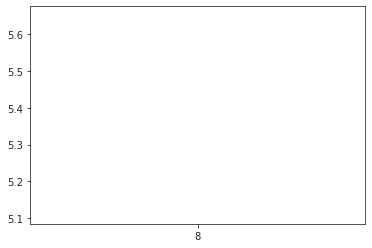

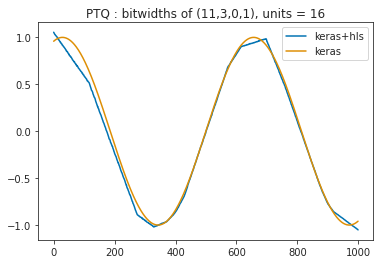

PTQ : bitwidths of (12,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

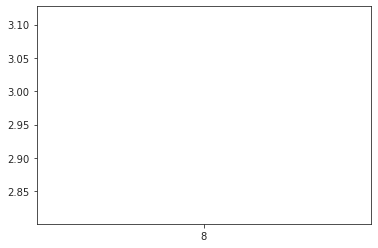

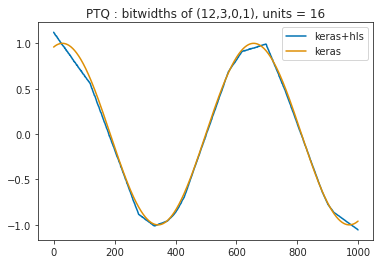

PTQ : bitwidths of (13,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

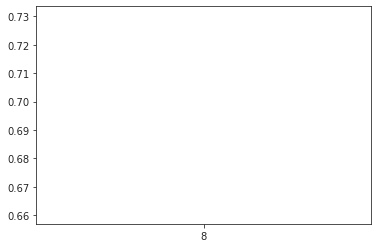

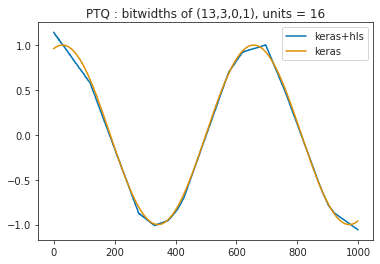

PTQ : bitwidths of (14,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

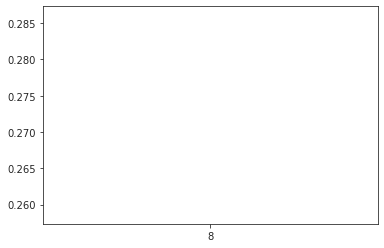

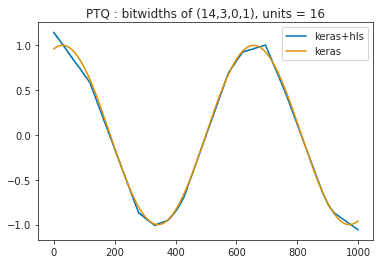

PTQ : bitwidths of (15,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

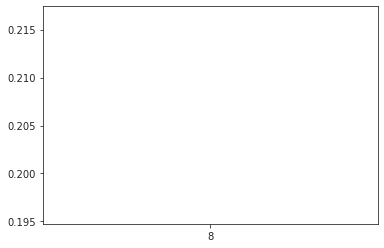

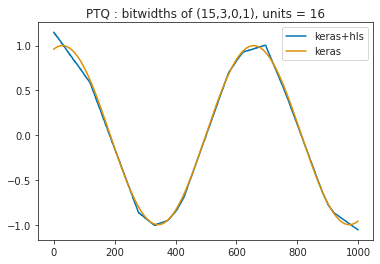

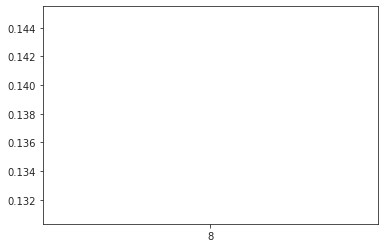

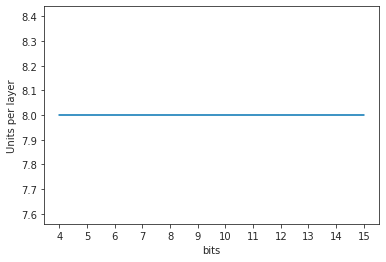

In [53]:
#HLS CONVERSION of the Keras model

closs = []
qcloss = []
qchloss = []
ptq_results = []
breaking_points = [] 

bit_scale = []
for i in range (bits_range):
    breaking_point = units(0)
    mse_ratio = []        
    bit_scale.append(bit_lenghts(i))
    unit_scale = []

    print(f'PTQ : bitwidths of ({bit_lenghts(i)},{integer},0,1), units = {units(j)}')
    conf = hls4ml.utils.config_from_keras_model( tf.keras.models.load_model(models_path(j)), granularity='name')
    conf['LayerName']['dense']['Precision']['weight'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
    conf['LayerName']['dense']['Precision']['bias'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'

    conf['LayerName']['dense_1']['Precision']['weight'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
    conf['LayerName']['dense_1']['Precision']['bias'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'


    conf['LayerName']['dense_2']['Precision']['weight'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
    conf['LayerName']['dense_2']['Precision']['bias'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'

    print(conf)
        
    hls_model = hls4ml.converters.convert_from_keras_model(tf.keras.models.load_model(models_path(j)),
                                                            hls_config=conf,
                                                            output_dir='models/hls_models',
                                                            part='1SG280HU2F50E2VG',
                                                            backend='Quartus')
    hls_model.compile()
    y_qchls = exist(qpredicts_path_PTQ(i,j), hls_model)

    ptq_results.append(y_qchls)
    unit_scale.append(units(j))

    y_keras = existnorm(predicts_path(j), tf.keras.models.load_model(models_path(j)))
    closs.append(mse(y_test, y_keras))
    qchloss.append(mse(y_test, y_qchls))
    mse_ratio.append((abs(mse(y_test, y_keras) - mse(y_test, y_qchls))/mse(y_test, y_keras)))
    if  ((abs(mse(y_test, y_keras) - mse(y_test, y_qchls))/mse(y_test, y_keras))>0.02):
        print('new bp detected')
        breaking_point = units(j)

    plt.figure()
    plt.plot(y_qchls)
    plt.plot(y_test)    
    plt.legend(['keras+hls', 'keras'])
    plt.title(f'PTQ : bitwidths of ({bit_lenghts(i)},{integer},0,1), units = {units(j)*2}')
    plt.show()
    breaking_points.append(breaking_point)
    plt.figure()
    plt.plot(mse_ratio)
    plt.xticks(np.arange(len(unit_scale)), [f"{unit}" for unit in unit_scale])
   

plt.figure()
plt.plot(breaking_points)
plt.xlabel('bits')
plt.ylabel('Units per layer')
plt.xticks(np.arange(len(bit_scale)), [f"{bit}" for bit in bit_scale])

plt.show()



## HLS QAT : CONVERSION of the QKeras model

QAT : bitwidths of (4,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_6_input, layer type: Input
Layer name: q_dense_6, layer type: QDense
Layer name: q_dense_7, layer type: QDense
Layer name: q_dense_8, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_6_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_6': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_7': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_8': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_6_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_6, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_7, layer type: QDense, input shapes: [[None, 8]], output shape

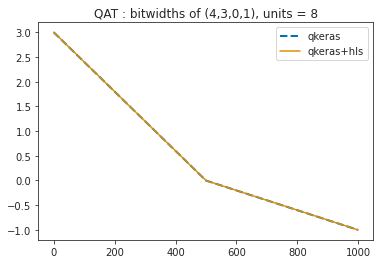

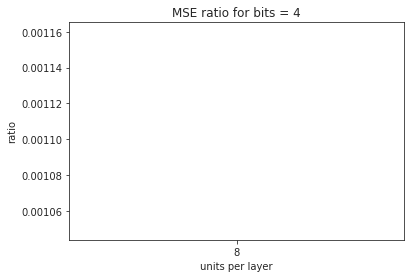

QAT : bitwidths of (5,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_42_input, layer type: Input
Layer name: q_dense_42, layer type: QDense
Layer name: q_dense_43, layer type: QDense
Layer name: q_dense_44, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_42_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_42': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_43': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_44': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_42_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_42, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_43, layer type: QDense, inpu

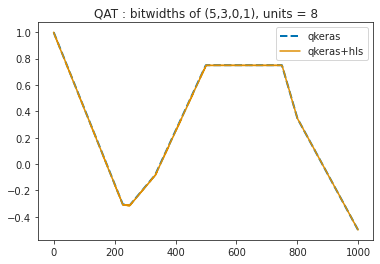

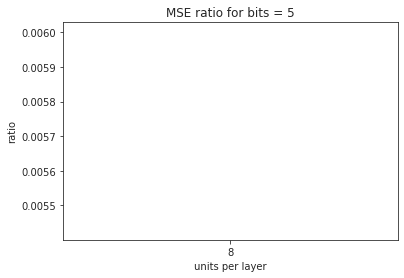

QAT : bitwidths of (6,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_78_input, layer type: Input
Layer name: q_dense_78, layer type: QDense
Layer name: q_dense_79, layer type: QDense
Layer name: q_dense_80, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_78_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_78': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_79': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_80': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_78_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_78, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_79, layer type: QDense, inpu

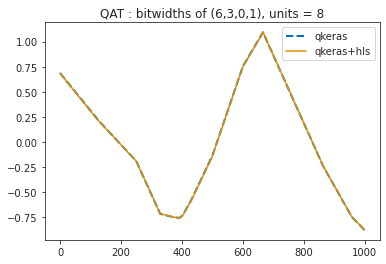

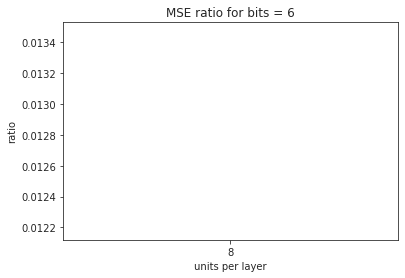

QAT : bitwidths of (7,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_114_input, layer type: Input
Layer name: q_dense_114, layer type: QDense
Layer name: q_dense_115, layer type: QDense
Layer name: q_dense_116, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_114_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_114': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_115': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_116': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_114_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_114, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_115, layer type: Q

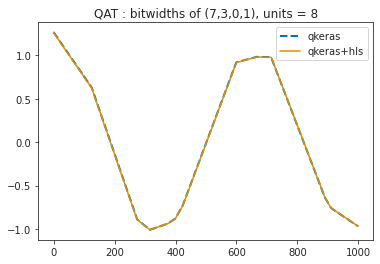

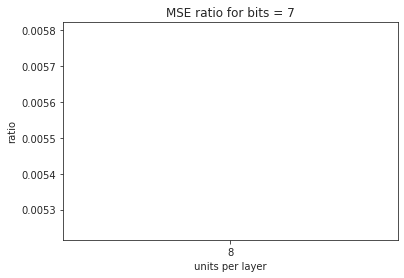

QAT : bitwidths of (8,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_150_input, layer type: Input
Layer name: q_dense_150, layer type: QDense
Layer name: q_dense_151, layer type: QDense
Layer name: q_dense_152, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_150_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_150': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_151': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_152': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_150_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_150, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_151, layer type: Q

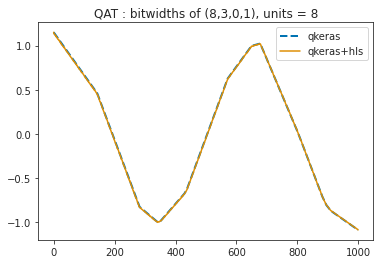

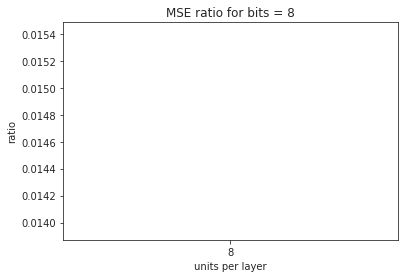

QAT : bitwidths of (9,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_186_input, layer type: Input
Layer name: q_dense_186, layer type: QDense
Layer name: q_dense_187, layer type: QDense
Layer name: q_dense_188, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_186_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_186': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_187': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_188': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_186_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_186, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_187, layer type: Q

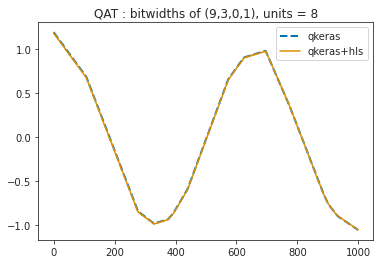

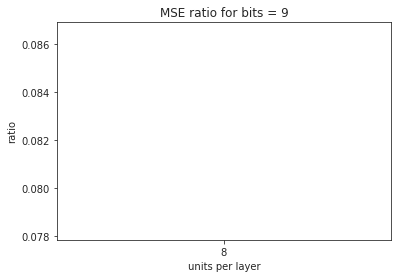

QAT : bitwidths of (10,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_222_input, layer type: Input
Layer name: q_dense_222, layer type: QDense
Layer name: q_dense_223, layer type: QDense
Layer name: q_dense_224, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_222_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_222': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_223': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_224': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_222_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_222, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_223, layer 

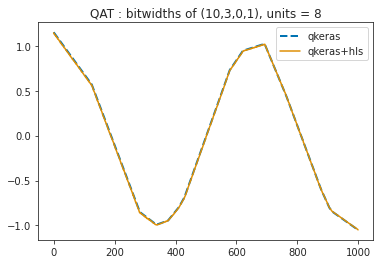

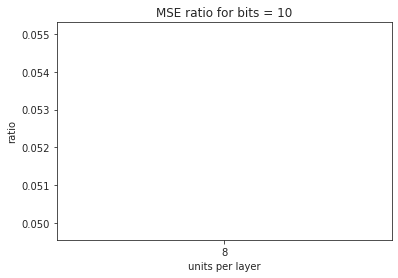

QAT : bitwidths of (11,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_258_input, layer type: Input
Layer name: q_dense_258, layer type: QDense
Layer name: q_dense_259, layer type: QDense
Layer name: q_dense_260, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_258_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_258': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_259': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_260': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_258_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_258, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_259, layer 

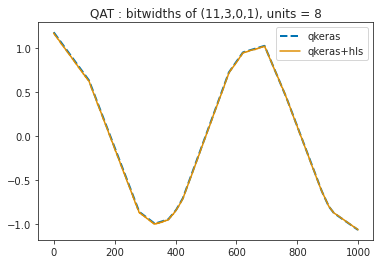

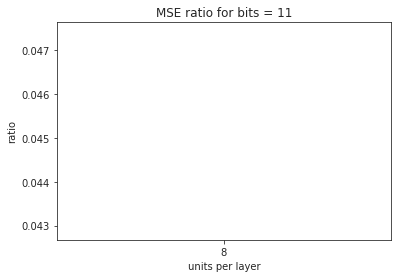

QAT : bitwidths of (12,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_294_input, layer type: Input
Layer name: q_dense_294, layer type: QDense
Layer name: q_dense_295, layer type: QDense
Layer name: q_dense_296, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_294_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_294': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_295': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_296': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_294_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_294, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_295, layer 

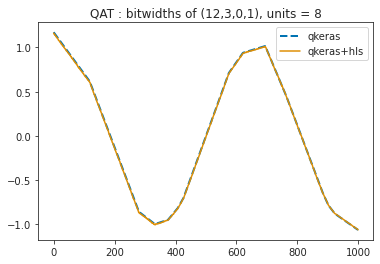

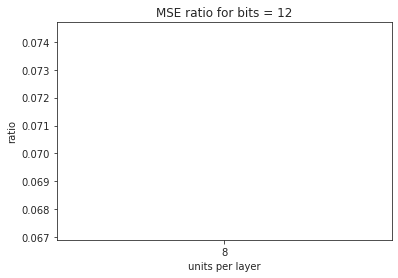

QAT : bitwidths of (13,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_330_input, layer type: Input
Layer name: q_dense_330, layer type: QDense
Layer name: q_dense_331, layer type: QDense
Layer name: q_dense_332, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_330_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_330': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_331': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_332': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_330_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_330, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_331, layer 

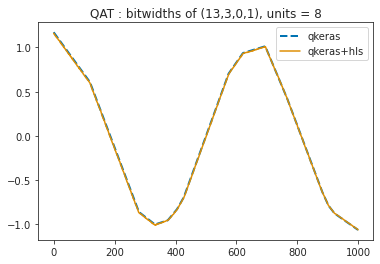

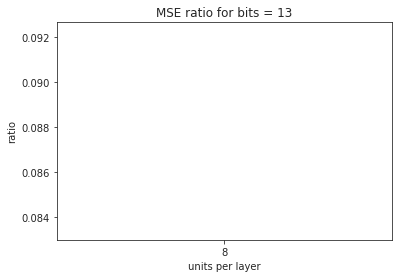

QAT : bitwidths of (14,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_366_input, layer type: Input
Layer name: q_dense_366, layer type: QDense
Layer name: q_dense_367, layer type: QDense
Layer name: q_dense_368, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_366_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_366': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_367': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_368': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_366_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_366, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_367, layer 

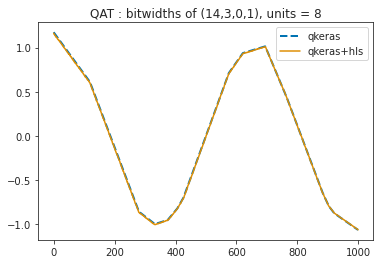

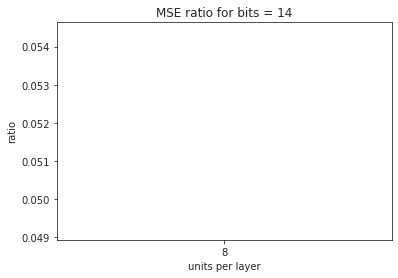

QAT : bitwidths of (15,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_402_input, layer type: Input
Layer name: q_dense_402, layer type: QDense
Layer name: q_dense_403, layer type: QDense
Layer name: q_dense_404, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_402_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_402': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_403': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_404': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_402_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_402, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_403, layer 

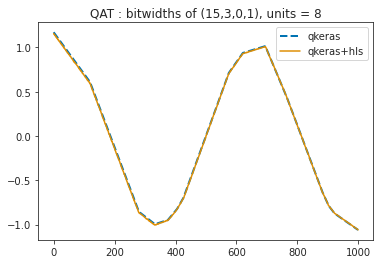

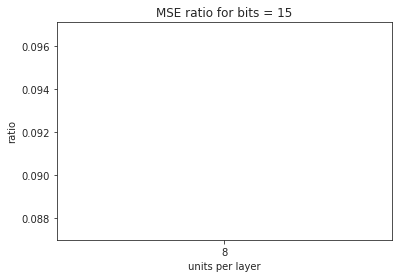

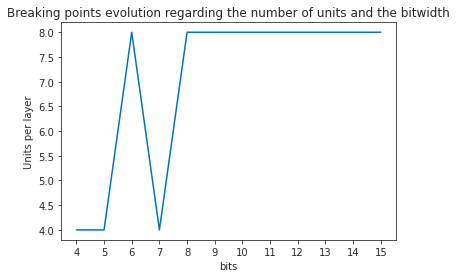

In [54]:
#Taking the quantized model and converting it to HLS with the same quantization 
breaking_points = [] 
bits_nbr = []
qat_results = []
qloss = []
qhloss = []
bit_scale = []

for i in range (bits_range):
    breaking_point = units(0)
    units_nbr = []
    mse_ratio = []
    bit_scale.append(bit_lenghts(i))

    unit_scale = []

    print(f'QAT : bitwidths of ({bit_lenghts(i)},{integer},0,1), units = {units(j)}')
    conf = hls4ml.utils.config_from_keras_model(qkeras.utils.load_qmodel(qmodels_path(i,j)), granularity='name')
    print(conf)

    hls_qmodel = hls4ml.converters.convert_from_keras_model(qkeras.utils.load_qmodel(qmodels_path(i,j)),
                                                        hls_config=conf,
                                                        output_dir='models/hls_models',
                                                        part='1SG280HU2F50E2VG',
                                                        backend='Quartus')
                                
    hls_qmodel.compile()

    y_qkeras = existnorm(qpredicts_path(i,j),qkeras.utils.load_qmodel(qmodels_path(i,j) ))
    y_qhls = exist(qpredicts_path_QAT(i,j), hls_qmodel)

    
    qat_results.append(y_qhls)
    
    
    qhloss.append(mse(y_test, y_qhls))
    qloss.append(mse(y_test, y_qkeras))
    
    unit_scale.append(units(j))
    
    #Implementation of the breaking point
    ratio =(abs(mse(y_test, y_qkeras) - mse(y_test, y_qhls))/mse(y_test, y_qkeras))
    print(f'ratio of bits = {bit_lenghts(i)} and units =  {units(j)}',ratio)
    mse_ratio.append(ratio)
    if  (ratio>0.01):
        print('new bp detected')
        breaking_point = units(j)

    #Plotting of the predictions
    plt.figure()
    plt.plot(y_qkeras, '--', linewidth=2)
    plt.plot(y_qhls)    
    plt.legend(['qkeras', 'qkeras+hls'])
    plt.title(f'QAT : bitwidths of ({bit_lenghts(i)},{integer},0,1), units = {units(j)}')
    plt.show()
       
    


    #plotting of the evolution of the breaking points through the number of units with a given a bit lenghts
    breaking_points.append(breaking_point)
    bits_nbr.append(bit_lenghts(i))
    plt.figure()
    plt.plot(mse_ratio)
    plt.xticks(np.arange(len(unit_scale)), [f"{unit}" for unit in unit_scale])
    plt.xlabel('units per layer')
    plt.ylabel('ratio')

    plt.title(f'MSE ratio for bits = {bit_lenghts(i)}')

    plt.show()

plt.figure()
plt.plot(breaking_points)
plt.xlabel('bits')
plt.ylabel('Units per layer')
plt.xticks(np.arange(len(bit_scale)), [f"{bit}" for bit in bit_scale])
plt.title('Breaking points evolution regarding the number of units and the bitwidth')

plt.show()


## Results

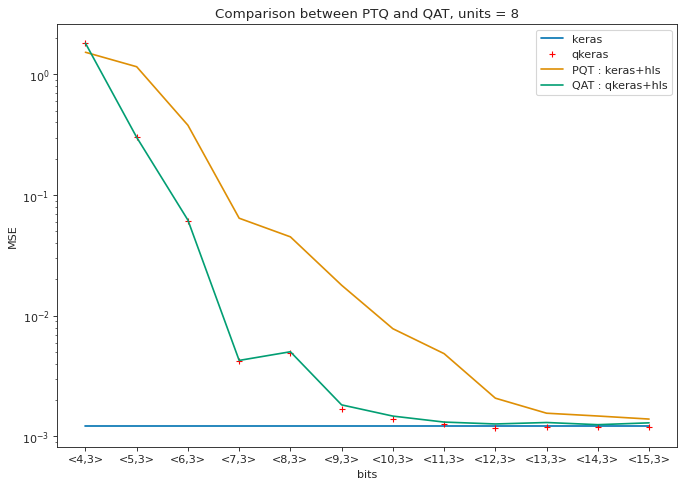

In [55]:
plt.figure(figsize=(10, 7), dpi=80)
plt.plot(closs)
plt.plot(qloss, 'r+')
plt.plot(qchloss)
plt.plot(qhloss)   
plt.legend(['keras','qkeras','PQT : keras+hls',  'QAT : qkeras+hls'])
plt.yscale("log")
plt.xlabel('bits')
plt.ylabel('MSE')
plt.title(f'Comparison between PTQ and QAT, units = {units(j)}')
plt.xticks(np.arange(len(bits_nbr)), [f"<{bits},{integer}>" for bits in bits_nbr])
plt.show()



## Analyse of the weights

(array([1., 3., 8., 2., 8., 7., 1., 0., 0., 1.]),
 array([-2.4798443 , -1.9255514 , -1.3712585 , -0.8169656 , -0.26267266,
         0.29162025,  0.8459132 ,  1.4002061 ,  1.954499  ,  2.508792  ,
         3.0630848 ], dtype=float32),
 <BarContainer object of 10 artists>)

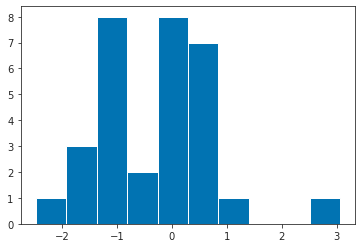

In [ ]:
plt.hist(np.concatenate([i.flatten() for i in d_model.get_weights()]))



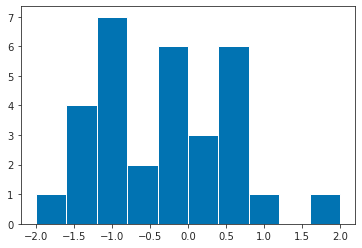

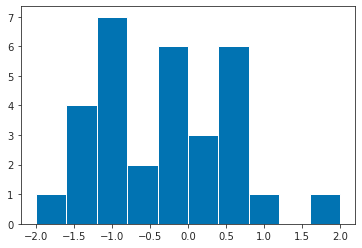

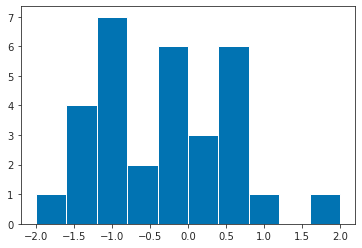

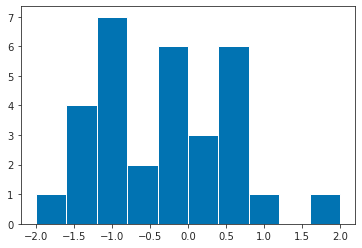

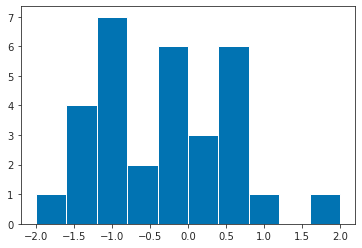

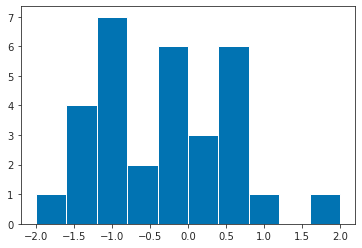

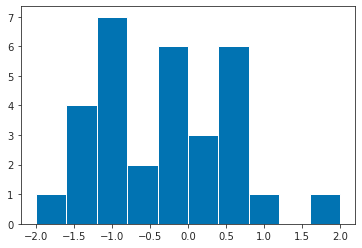

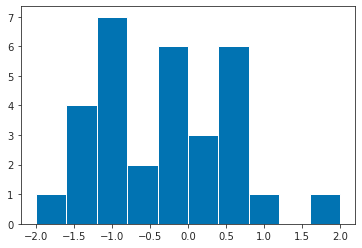

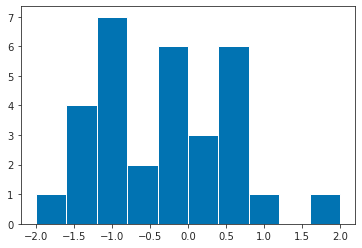

In [ ]:
for qm in qmodels:
    plt.hist(np.concatenate([i.flatten() for i in qm.get_weights()]))
    plt.show()